# Optimal Classification Tree

This notebook document is a **python** implementation for two new methods of Optimal Classification Trees proposed by Enhao Liu and Theodore Allen: (1) Modified-Optimal Classification Tree (M-OCT) and (2) BinaryNodePenalty-Optimal Classification Tree (BNP-OCT)

Contact: Enhao Liu (liu.5045@osu.edu), Theodre Allen (allen.515@osu.edu)

# Library Settings

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

from lsopt.tree import OptimalTreeClassifier ## M-OCT propsed by Liu & Allen
from lsopt.tree import BinNodePenaltyOptimalTreeClassifier ## BNP-OCT propsed by Liu & Allen
# from lsopt.tree import OldOptimalTreeClassifier ## OCT proposed by Bertsimas & Dunn

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree 

import graphviz

%load_ext autoreload
%autoreload 2

# Optimal Classification Tree

## Example: Iris Dataset

In [2]:
data_path = './data/Iris.csv'

iris_data = pd.read_csv(data_path)
iris_data.drop(columns=["Id"], inplace=True)

In [3]:
data_path_fraud = './data/fraud_data_m_oct_ready.csv'
fraud_data = pd.read_csv(data_path_fraud)

In [4]:
display(iris_data)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [5]:
fraud_data

,phy_same,phy_count,period,periodadmt,age,alife,provider_InscClaimAmtReimbursed_mean,provider_DeductibleAmtPaid_mean,provider_NoOfMonths_PartACov_mean,provider_NoOfMonths_PartBCov_mean,...,diag1_OPAnnualDeductibleAmt_mean,diag1_InscClaimAmtReimbursed_std,diag1_DeductibleAmtPaid_std,diag1_NoOfMonths_PartACov_std,diag1_NoOfMonths_PartBCov_std,diag1_IPAnnualReimbursementAmt_std,diag1_IPAnnualDeductibleAmt_std,diag1_OPAnnualReimbursementAmt_std,diag1_OPAnnualDeductibleAmt_std,PotentialFraud
0,2.960000,1.600000,1.440000,1.000000,80.240000,1.000000,4185.600000,213.600000,12.000000,12.000000,...,543.045084,3482.066310,161.353027,0.569945,0.424192,12941.552350,1205.297144,2450.076771,661.506672,Not-Fraud
1,2.439394,1.530303,3.674242,2.424242,71.371212,0.992424,4588.409091,502.166667,11.818182,11.871212,...,676.313985,4017.871066,260.257069,0.726572,0.653285,12620.604410,1226.306633,3369.338617,848.213675,Fraud
2,2.818792,1.604027,1.429530,0.000000,73.516779,0.993289,350.134228,2.080537,11.865772,11.959732,...,694.246881,1536.290845,113.086257,0.667719,0.577420,11016.516940,1111.592405,2972.377916,808.138208,Not-Fraud
3,2.731330,1.599142,1.088412,0.000000,71.783691,0.996567,241.124463,3.175966,11.907296,11.939914,...,630.805985,1234.005090,91.141252,0.657071,0.565930,10021.329570,957.701391,2727.944083,737.419878,Fraud
4,2.736111,1.527778,0.958333,0.222222,70.583333,0.986111,468.194444,45.333333,11.833333,11.833333,...,606.550334,1519.425993,103.302166,0.626542,0.520122,10565.761430,1126.358206,2486.827069,682.279276,Not-Fraud
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,2.548387,1.548387,2.806452,0.000000,75.677419,1.000000,127.741935,1.612903,12.000000,12.000000,...,539.926413,1278.578369,105.316369,0.642724,0.506470,10069.067870,1048.496358,2331.087492,676.226785,Not-Fraud
1005,2.500000,1.500000,0.100000,0.000000,78.000000,1.000000,72.000000,0.000000,12.000000,12.000000,...,544.784235,589.615472,61.510304,0.690826,0.473344,10885.075840,1026.840019,2547.341333,723.822292,Not-Fraud
1006,3.000000,2.000000,0.000000,0.000000,74.000000,1.000000,50.000000,0.000000,12.000000,12.000000,...,613.157895,4778.012673,463.684066,0.600751,0.710275,13241.321690,1469.095843,3203.267596,911.406530,Not-Fraud
1007,2.333333,1.333333,2.266667,0.000000,73.933333,1.000000,296.000000,0.000000,12.000000,12.000000,...,566.953462,2506.463260,131.832995,0.726815,0.354062,11262.841610,1196.045563,2691.729344,736.415563,Not-Fraud


In [6]:
X = iris_data.iloc[:, 0:4].to_numpy()
y = iris_data["Species"].to_numpy()

In [7]:
X_fraud = fraud_data.drop(axis=1, columns=['PotentialFraud']).to_numpy()
y_fraud = fraud_data["PotentialFraud"].apply(lambda val: 0 if val == "Not-Fraud" else 1).to_numpy()

In [15]:
# from sklearn.preprocessing import RobustScaler
# #Standardize the data (train and test)
# robust_scaler = RobustScaler()
# robust_scaler.fit(X_fraud)
# X_fraud_std = robust_scaler.transform(X_fraud)

In [8]:
def split(df,label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df, label, test_size=0.2, random_state=42)
    return X_tr, X_te, Y_tr, Y_te

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from xgboost import XGBClassifier
import random

classifiers = ['LinearSVM', 'RadialSVM', 
               'Logistic',  'RandomForest', 
               'AdaBoost',  'DecisionTree', 
               'KNeighbors','GradientBoosting']

models = [svm.SVC(kernel='linear'),
          svm.SVC(kernel='rbf'),
          LogisticRegression(max_iter = 1000),
          RandomForestClassifier(n_estimators=200, random_state=0),
          AdaBoostClassifier(random_state = 0),
          DecisionTreeClassifier(random_state=0),
          KNeighborsClassifier(),
          XGBClassifier(random_state=0)]


def acc_score(df,label):
    Score = pd.DataFrame({"Classifier":classifiers})
    j = 0
    acc = []
    X_train,X_test,Y_train,Y_test = split(df,label)
    for i in models:
        model = i
        model.fit(X_train,Y_train)
        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test,predictions))
        j = j+1     
    Score["Accuracy"] = acc
    Score.sort_values(by="Accuracy", ascending=False,inplace = True)
    Score.reset_index(drop=True, inplace=True)
    return Score

def plot(score,x,y,c = "b"):
    gen = [1,2,3,4,5]
    plt.figure(figsize=(6,4))
    ax = sns.pointplot(x=gen, y=score,color = c )
    ax.set(xlabel="Generation", ylabel="Accuracy")
    ax.set(ylim=(x,y))
    
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=bool)     
        chromosome[:int(0.3*n_feat)]=False             
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population


def fitness_score(population):
    scores = []
    for chromosome in population:
        logmodel.fit(X_train[:, chromosome],Y_train)         
        predictions = logmodel.predict(X_test[:, chromosome])
        scores.append(accuracy_score(Y_test,predictions))
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)                                    
    return list(scores[inds][::-1]), list(population[inds,:][::-1]) 

def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen


def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
        new_par = []
        child_1 , child_2 = pop_nextgen[i] , pop_nextgen[i+1]
        new_par = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen

def mutation(pop_after_cross,mutation_rate,n_feat):   
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = [] 
        for i in range(0,mutation_range):
            pos = random.randint(0,n_feat-1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]  
        pop_next_gen.append(chromo)
    return pop_next_gen

def generations(df,label,size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                   X_test, Y_train, Y_test):
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        print('Best score in generation',i+1,':',scores[:1])  #2
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo,best_score

# Accuracy score below
Accuracy score is 1.0 for all the models, and similarly for all generations of XGBoost used with the GA.

In [9]:
score = acc_score(X_fraud, y_fraud)
score

In [71]:
logmodel = XGBClassifier(random_state=0)
X_train,X_test, Y_train, Y_test = split(X, y)
chromo_df_bc,score_bc=generations(X,y,size=80,n_feat=X.shape[1],n_parents=64,mutation_rate=0.20,n_gen=5,
                         X_train = X_train,X_test = X_test,Y_train = Y_train,Y_test = Y_test)

Best score in generation 1 : [1.0]
Best score in generation 2 : [1.0]
Best score in generation 3 : [1.0]
Best score in generation 4 : [1.0]
Best score in generation 5 : [1.0]


In [72]:
chromo_df_bc

[array([False,  True,  True,  True]),
 array([False,  True,  True,  True]),
 array([ True,  True,  True,  True]),
 array([False,  True,  True,  True]),
 array([False,  True,  True,  True])]

### M-OCT

The M-OCT is a modified version of the original OCT formulation (Bertsimas & Dunn, 2017). In the M-OCT formulation, we consider new leaf-branch-interaction constraints to ensure valid tree structure when learning the optimal trees.

In [79]:
from lsopt.tree import OptimalTreeClassifier ## M-OCT propsed by Liu & Allen
from lsopt.tree import BinNodePenaltyOptimalTreeClassifier ## BNP-OCT propsed by Liu & Allen

# OCT parameters
max_depth = 3
min_samples_leaf = 3
alpha = 0.01
time_limit = 10  # minute
mip_gap_tol = 0.05  # optimal gap percentage
mip_focus = 'balance'
mip_polish_time = None
warm_start = False
log_file = None
fp_heur = True
backtrack = "bestb"

# Construct OCT classifier
oct_model = OptimalTreeClassifier(max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf,
                                  alpha=alpha,
                                  criterion="gini",
                                  solver="glpk",
                                  time_limit=time_limit,
                                  verbose=True,
                                  warm_start=warm_start,
                                  log_file=log_file,
                                  solver_options={'mip_cuts': None,
                                                  'mip_gap_tol': mip_gap_tol,
                                                  'fp_heur': fp_heur,
                                                  'backtrack': backtrack
                                                  }
                                  )

# Construct BNP-OCT classifier
bnp_oct_model = BinNodePenaltyOptimalTreeClassifier(max_depth=max_depth,min_samples_leaf=min_samples_leaf,
                                  alpha=alpha,
                                  criterion="gini",
                                  solver="glpk",
                                  time_limit=time_limit,
                                  verbose=True,
                                  warm_start=warm_start,
                                  log_file=log_file,
                                  solver_options={'mip_cuts': None,
                                                  'mip_gap_tol': mip_gap_tol,
                                                  'fp_heur': fp_heur,
                                                  'backtrack': backtrack
                                                  }
                                  )

In [80]:
bnp_oct_model.fit(X, y)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --tmlim 600 --mipgap 0.05 --fpump --bestb --write /var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmp7w2dbn2u.glpk.raw
 --wglp /var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpj__a5t2c.glpk.glp
 --cpxlp /var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmp5besmo4f.pyomo.lp
Reading problem data from '/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmp5besmo4f.pyomo.lp'...
/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmp5besmo4f.pyomo.lp:44228: warning: lower bound of variable 'x11' redefined
/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmp5besmo4f.pyomo.lp:44228: warning: upper bound of variable 'x11' redefined
2852 rows, 1340 columns, 34307 non-zeros
99 integer variables, all of which are binary
44327 lines were read
Writing problem data to '/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpj__a5t2c.glpk.glp'...
42566 lines were written
GLPK Integer Optimizer 5.0
2852 rows, 1340 columns, 34307 non

In [61]:
oct_model.fit(X_fraud, y_fraud)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --tmlim 600 --mipgap 0.05 --fpump --bestb --write /var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpdghaufbs.glpk.raw
 --wglp /var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpn2j94gco.glpk.glp
 --cpxlp /var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpvi_w1h9q.pyomo.lp
Reading problem data from '/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpvi_w1h9q.pyomo.lp'...
/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpvi_w1h9q.pyomo.lp:1269579: warning: lower bound of variable 'x11' redefined
/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpvi_w1h9q.pyomo.lp:1269579: warning: upper bound of variable 'x11' redefined
33403 rows, 8448 columns, 1160897 non-zeros
8408 integer variables, all of which are binary
1277987 lines were read
Writing problem data to '/var/folders/kb/sxk47lqj0xd8j0x92mykb0rr0000gn/T/tmpn2j94gco.glpk.glp'...
1236173 lines were written
GLPK Integer Optimizer 5.0
33403 rows, 8448 colu

In [28]:
# Fit
bnp_oct_model.fit(X_fraud, y_fraud)


--------------------------------------------
--------------------------------------------

Read LP format model from file C:\Users\user\AppData\Local\Temp\tmpf37889ns.pyomo.lp
Reading time = 1.35 seconds
x1: 33403 rows, 8468 columns, 1233566 nonzeros
Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-4600U CPU @ 2.10GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 33403 rows, 8468 columns and 1233566 nonzeros
Model fingerprint: 0x834c3dde
Variable types: 39 continuous, 8429 integer (8429 binary)
Coefficient statistics:
  Matrix range     [1e-06, 1e+03]
  Objective range  [9e-03, 9e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 2029 rows and 42 columns
Presolve time: 3.64s
Presolved: 31374 rows, 8426 columns, 1026935 nonzeros
Variable types: 16 cont

In [81]:
# Make prediction
y_pred = bnp_oct_model.predict(X=X)
y_pred_prob = bnp_oct_model.predict_proba(X=X)

# Check confusion matrix
print("Confusion Matrix :")
print(confusion_matrix(y_true=y,
                       y_pred=y_pred))

print(classification_report(y_true=y,
                            y_pred=y_pred))

# Plot Optimal Tree
feature_names = iris_data.columns.values[:4]
class_names = np.unique(y)

dot_data = tree.export_graphviz(bnp_oct_model,
                                out_file=None,
                                feature_names=feature_names,
                                class_names=class_names,
                                label='all',
                                impurity=True,
                                node_ids=True,
                                filled=True,
                                rounded=True,
                                leaves_parallel=True,
                                special_characters=False)

graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render(filename='optimal_tree_iris', directory='', view=True)

Confusion Matrix :
[[50  0  0]
 [ 0 48  2]
 [ 0  2 48]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        50
Iris-versicolor       0.96      0.96      0.96        50
 Iris-virginica       0.96      0.96      0.96        50

       accuracy                           0.97       150
      macro avg       0.97      0.97      0.97       150
   weighted avg       0.97      0.97      0.97       150



'optimal_tree_iris.png'

In [62]:
# Make prediction
y_pred = bnp_oct_model.predict(X=X_fraud)
y_pred_prob = bnp_oct_model.predict_proba(X=X_fraud)

# Check confusion matrix
print("Confusion Matrix :")
print(confusion_matrix(y_true=y_fraud,
                       y_pred=y_pred))

print(classification_report(y_true=y_fraud,
                            y_pred=y_pred))

# Plot Optimal Tree
feature_names = fraud_data.drop(axis=1, columns=['provider_NoOfMonths_PartACov_mean', 'provider_NoOfMonths_PartBCov_mean','PotentialFraud', 'provider_NoOfMonths_PartACov_std','provider_NoOfMonths_PartBCov_std']).columns.values
class_names = np.unique(y_fraud)

dot_data = tree.export_graphviz(bnp_oct_model,
                                out_file=None,
                                feature_names=feature_names,
                                class_names=class_names,
                                label='all',
                                impurity=True,
                                node_ids=True,
                                filled=True,
                                rounded=True,
                                leaves_parallel=True,
                                special_characters=False)

graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render(filename='optimal_tree_fraud', directory='', view=True)

NotFittedError: This BinNodePenaltyOptimalTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

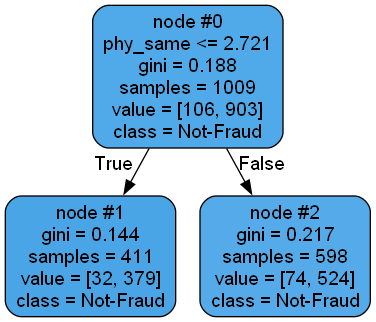

In [ ]:
Image('optimal_tree_iris.png')

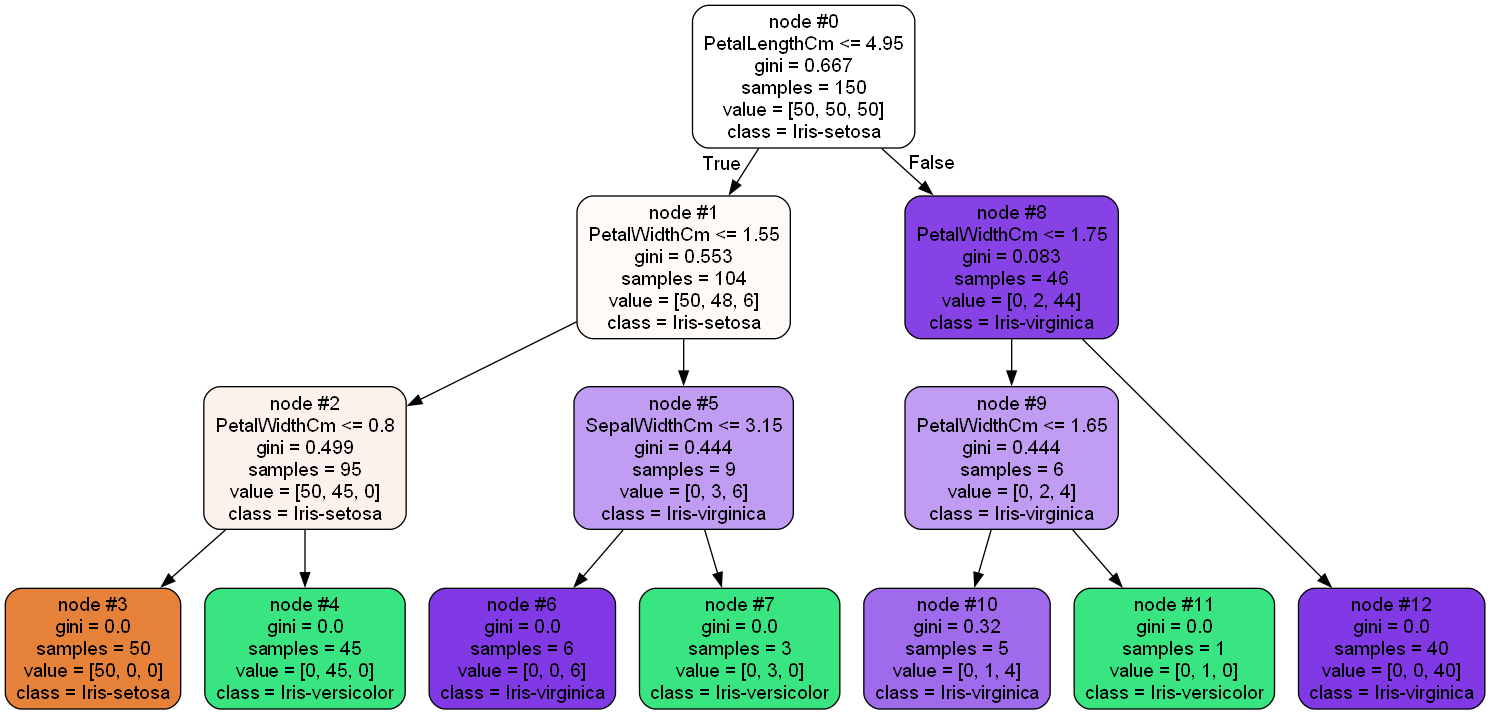

In [16]:
Image('optimal_tree_iris.png')

### Greedy : CART

In [ ]:
## Fit CART
cart_model = tree.DecisionTreeClassifier(max_depth=3, criterion="gini")
cart_model.fit(X, y)


## Make prediction
y_pred = cart_model.predict(X)
y_pred_prob = cart_model.predict_proba(X=X)

# Check confusion matrix
print("Confusion Matrix :")
print(confusion_matrix(y_true=y,
                       y_pred=y_pred))

print(classification_report(y_true=y,
                            y_pred=y_pred))

# Plot Greedy Tree
feature_names = iris_data.columns.values[:4]
class_names = np.unique(y)

dot_data = tree.export_graphviz(cart_model,
                                out_file=None,
                                feature_names=feature_names,
                                class_names=class_names,
                                label='all',
                                impurity=True,
                                node_ids=True,
                                filled=True,
                                rounded=True,
                                leaves_parallel=True,
                                special_characters=False)

graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render(filename='greedy_tree_iris', directory='', view=True)


Confusion Matrix :
[[50  0  0]
 [ 0 47  3]
 [ 0  1 49]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        50
Iris-versicolor       0.98      0.94      0.96        50
 Iris-virginica       0.94      0.98      0.96        50

       accuracy                           0.97       150
      macro avg       0.97      0.97      0.97       150
   weighted avg       0.97      0.97      0.97       150



'greedy_tree_iris.png'

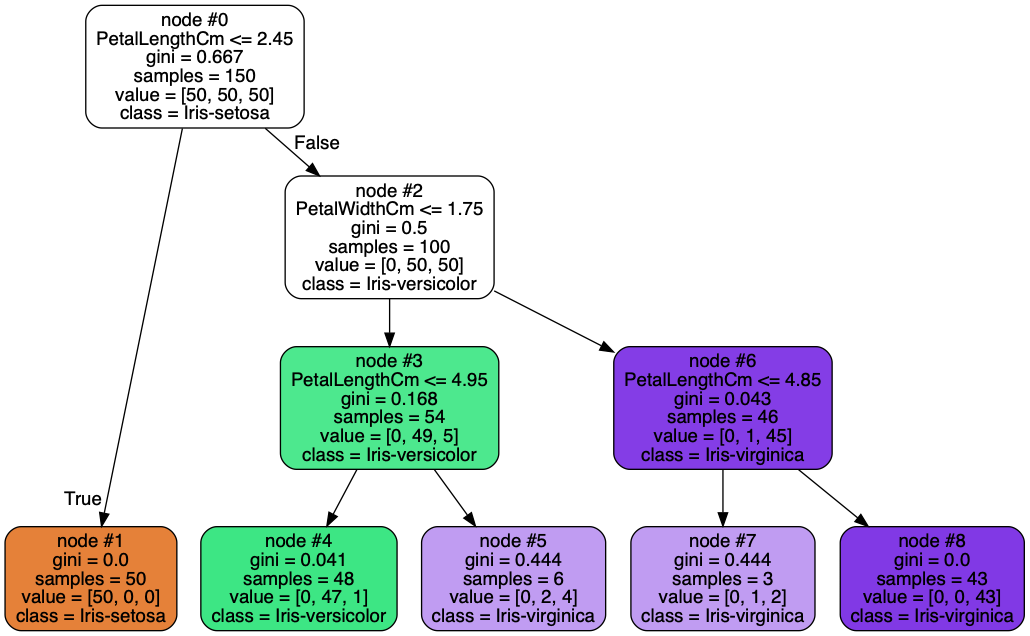

In [ ]:
Image('greedy_tree_iris.png')